In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
import warnings
warnings.filterwarnings('ignore')

def load_and_explore_data(file_path):
    df = pd.read_csv(file_path)

    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print("\nFirst few rows:")
    print(df.head())

    return df

def perform_eda(df):
    """
    Perform comprehensive exploratory data analysis
    """
    print("="*50)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*50)

    # Basic info
    print("\n1. Dataset Info:")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Data types
    print("\n2. Data Types:")
    print(df.dtypes.value_counts())

    # Missing values
    print("\n3. Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Count': missing,
        'Percentage': missing_pct
    })
    print(missing_df[missing_df['Count'] > 0])

    # Target distribution
    print("\n4. Target Variable Distribution:")
    churn_dist = df['Churn'].value_counts()
    print(churn_dist)
    print(f"Churn rate: {churn_dist['Yes'] / len(df) * 100:.2f}%")

    # Numerical features summary
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    print(f"\n5. Numerical Features Summary ({len(numerical_cols)} features):")
    print(df[numerical_cols].describe())

    # Categorical features summary
    categorical_cols = df.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if col not in ['customerID', 'Churn']]
    print(f"\n6. Categorical Features ({len(categorical_cols)} features):")
    for col in categorical_cols[:5]:  # Show first 5
        print(f"{col}: {df[col].nunique()} unique values")
        print(df[col].value_counts().head(3))
        print()

def create_visualizations(df):
    """
    Create comprehensive visualizations for EDA
    """
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Customer Churn Analysis - Key Insights', fontsize=16, fontweight='bold')

    # 1. Churn distribution
    churn_counts = df['Churn'].value_counts()
    axes[0,0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title('Overall Churn Distribution')

    # 2. Tenure vs Churn
    df_churn_yes = df[df['Churn'] == 'Yes']
    df_churn_no = df[df['Churn'] == 'No']
    axes[0,1].hist([df_churn_no['tenure'], df_churn_yes['tenure']],
                   label=['No Churn', 'Churn'], alpha=0.7, bins=20)
    axes[0,1].set_xlabel('Tenure (months)')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Tenure Distribution by Churn')
    axes[0,1].legend()

    # 3. Monthly charges vs Churn
    axes[0,2].boxplot([df_churn_no['MonthlyCharges'], df_churn_yes['MonthlyCharges']],
                      labels=['No Churn', 'Churn'])
    axes[0,2].set_ylabel('Monthly Charges ($)')
    axes[0,2].set_title('Monthly Charges by Churn Status')

    # 4. Contract type vs Churn
    contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
    contract_churn.plot(kind='bar', ax=axes[1,0], rot=45)
    axes[1,0].set_title('Churn Rate by Contract Type')
    axes[1,0].set_ylabel('Percentage')
    axes[1,0].legend(['No Churn', 'Churn'])

    # 5. Internet Service vs Churn
    internet_churn = pd.crosstab(df['InternetService'], df['Churn'], normalize='index') * 100
    internet_churn.plot(kind='bar', ax=axes[1,1], rot=45)
    axes[1,1].set_title('Churn Rate by Internet Service')
    axes[1,1].set_ylabel('Percentage')
    axes[1,1].legend(['No Churn', 'Churn'])

    # 6. Correlation heatmap for numerical features
    numerical_df = df.select_dtypes(include=[np.number])
    corr_matrix = numerical_df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
    axes[1,2].set_title('Numerical Features Correlation')

    plt.tight_layout()
    plt.show()

def prepare_features(df):
    """
    Prepare features and target variables for modeling
    """
    print("\n" + "="*50)
    print("FEATURE PREPARATION")
    print("="*50)

    # Remove customer ID
    df_model = df.drop(['customerID'], axis=1)

    # Handle TotalCharges if it's object type (common issue in Telco dataset)
    if df_model['TotalCharges'].dtype == 'object':
        df_model['TotalCharges'] = pd.to_numeric(df_model['TotalCharges'], errors='coerce')
        df_model['TotalCharges'].fillna(df_model['TotalCharges'].median(), inplace=True)

    # Separate features and target
    X = df_model.drop(['Churn'], axis=1)
    y = df_model['Churn']

    # Encode target variable
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Identify categorical and numerical features
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

    print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
    print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
    print(f"Target classes: {le.classes_}")

    return X, y, categorical_features, numerical_features, le

def create_preprocessing_pipeline(categorical_features, numerical_features):
    """
    Create preprocessing pipeline for categorical and numerical features
    """
    print("\nCreating preprocessing pipeline...")

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    print("Preprocessing pipeline created successfully!")
    return preprocessor

def create_model_pipeline(preprocessor, model, model_name):
    """
    Create a complete model pipeline with preprocessing and model
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    print(f"{model_name} pipeline created successfully!")
    return pipeline

def define_hyperparameter_grids():
    """
    Define hyperparameter grids for different models
    """
    param_grids = {
        'logistic_regression': {
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear']
        },
        'random_forest': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [10, 20, None],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2]
        }
    }
    return param_grids

def train_and_evaluate_models(X, y, categorical_features, numerical_features):
    """
    Train and evaluate multiple models with hyperparameter tuning
    """
    print("\n" + "="*50)
    print("MODEL TRAINING AND EVALUATION")
    print("="*50)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")

    # Create preprocessing pipeline
    preprocessor = create_preprocessing_pipeline(categorical_features, numerical_features)

    # Define models
    models = {
        'logistic_regression': LogisticRegression(random_state=42),
        'random_forest': RandomForestClassifier(random_state=42, n_jobs=-1)
    }

    # Get hyperparameter grids
    param_grids = define_hyperparameter_grids()

    results = {}
    best_models = {}

    for model_name, model in models.items():
        print(f"\nTraining {model_name.replace('_', ' ').title()}...")

        # Create pipeline
        pipeline = create_model_pipeline(preprocessor, model, model_name)

        # Hyperparameter tuning
        grid_search = GridSearchCV(
            pipeline,
            param_grids[model_name],
            cv=5,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )

        # Fit the model
        grid_search.fit(X_train, y_train)

        # Best model
        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model

        # Predictions
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)

        results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'test_auc': auc_score,
            'predictions': y_pred,
            'prediction_probabilities': y_pred_proba,
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")
        print(f"Test AUC: {auc_score:.4f}")

    return results, best_models, X_test, y_test

def plot_model_comparison(results, X_test, y_test):
    """
    Create comparison plots for model performance
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. AUC Comparison
    model_names = []
    auc_scores = []
    for model_name, result in results.items():
        model_names.append(model_name.replace('_', ' ').title())
        auc_scores.append(result['test_auc'])

    axes[0].bar(model_names, auc_scores, color=['skyblue', 'lightcoral'])
    axes[0].set_title('Model Comparison - AUC Scores')
    axes[0].set_ylabel('AUC Score')
    axes[0].set_ylim(0, 1)
    for i, score in enumerate(auc_scores):
        axes[0].text(i, score + 0.01, f'{score:.4f}', ha='center')

    # 2. ROC Curves
    for model_name, result in results.items():
        y_pred_proba = result['prediction_probabilities']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = result['test_auc']
        axes[1].plot(fpr, tpr, label=f'{model_name.replace("_", " ").title()} (AUC = {auc:.4f})')

    axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curves')
    axes[1].legend()
    axes[1].grid(True)

    # 3. Confusion Matrices
    model_names_list = list(results.keys())
    cm1 = results[model_names_list[0]]['confusion_matrix']
    cm2 = results[model_names_list[1]]['confusion_matrix']

    # Show confusion matrix for the best model (highest AUC)
    best_model_name = max(results.keys(), key=lambda k: results[k]['test_auc'])
    cm_best = results[best_model_name]['confusion_matrix']

    sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', ax=axes[2])
    axes[2].set_title(f'Confusion Matrix - {best_model_name.replace("_", " ").title()}')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

def export_best_pipeline(best_models, results, filename='best_churn_pipeline.joblib'):
    """
    Export the best performing pipeline
    """
    # Find best model based on test AUC
    best_model_name = max(results.keys(), key=lambda k: results[k]['test_auc'])
    best_pipeline = best_models[best_model_name]

    # Export pipeline
    joblib.dump(best_pipeline, filename)

    print(f"\n" + "="*50)
    print("PIPELINE EXPORT")
    print("="*50)
    print(f"Best model: {best_model_name.replace('_', ' ').title()}")
    print(f"Test AUC: {results[best_model_name]['test_auc']:.4f}")
    print(f"Pipeline exported to: {filename}")

    return best_model_name

def load_and_predict(filename, X_sample):
    """
    Load saved pipeline and make predictions
    """
    # Load pipeline
    loaded_pipeline = joblib.load(filename)

    # Make predictions
    predictions = loaded_pipeline.predict(X_sample)
    prediction_probabilities = loaded_pipeline.predict_proba(X_sample)

    print(f"\nPipeline loaded successfully from {filename}")
    print(f"Sample predictions: {predictions[:5]}")
    print(f"Sample probabilities: {prediction_probabilities[:5, 1]}")

    return predictions, prediction_probabilities

# Execute the complete ML pipeline
print(" Starting End-to-End ML Pipeline for Customer Churn Prediction")
print("="*70)

 Starting End-to-End ML Pipeline for Customer Churn Prediction


In [3]:
# Step 1: Load and explore data
df = load_and_explore_data('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

Dataset loaded successfully!
Shape: (7043, 21)

First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

In [4]:
# Step 2: Perform EDA
perform_eda(df)

EXPLORATORY DATA ANALYSIS

1. Dataset Info:
Shape: (7043, 21)
Memory usage: 7.42 MB

2. Data Types:
object     17
int64       2
float64     2
Name: count, dtype: int64

3. Missing Values:
Empty DataFrame
Columns: [Count, Percentage]
Index: []

4. Target Variable Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn rate: 26.54%

5. Numerical Features Summary (4 features):
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2281.916928
std         0.368612    24.559481       30.090047   2265.270398
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    402.225000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000

6. Categorical Features (1

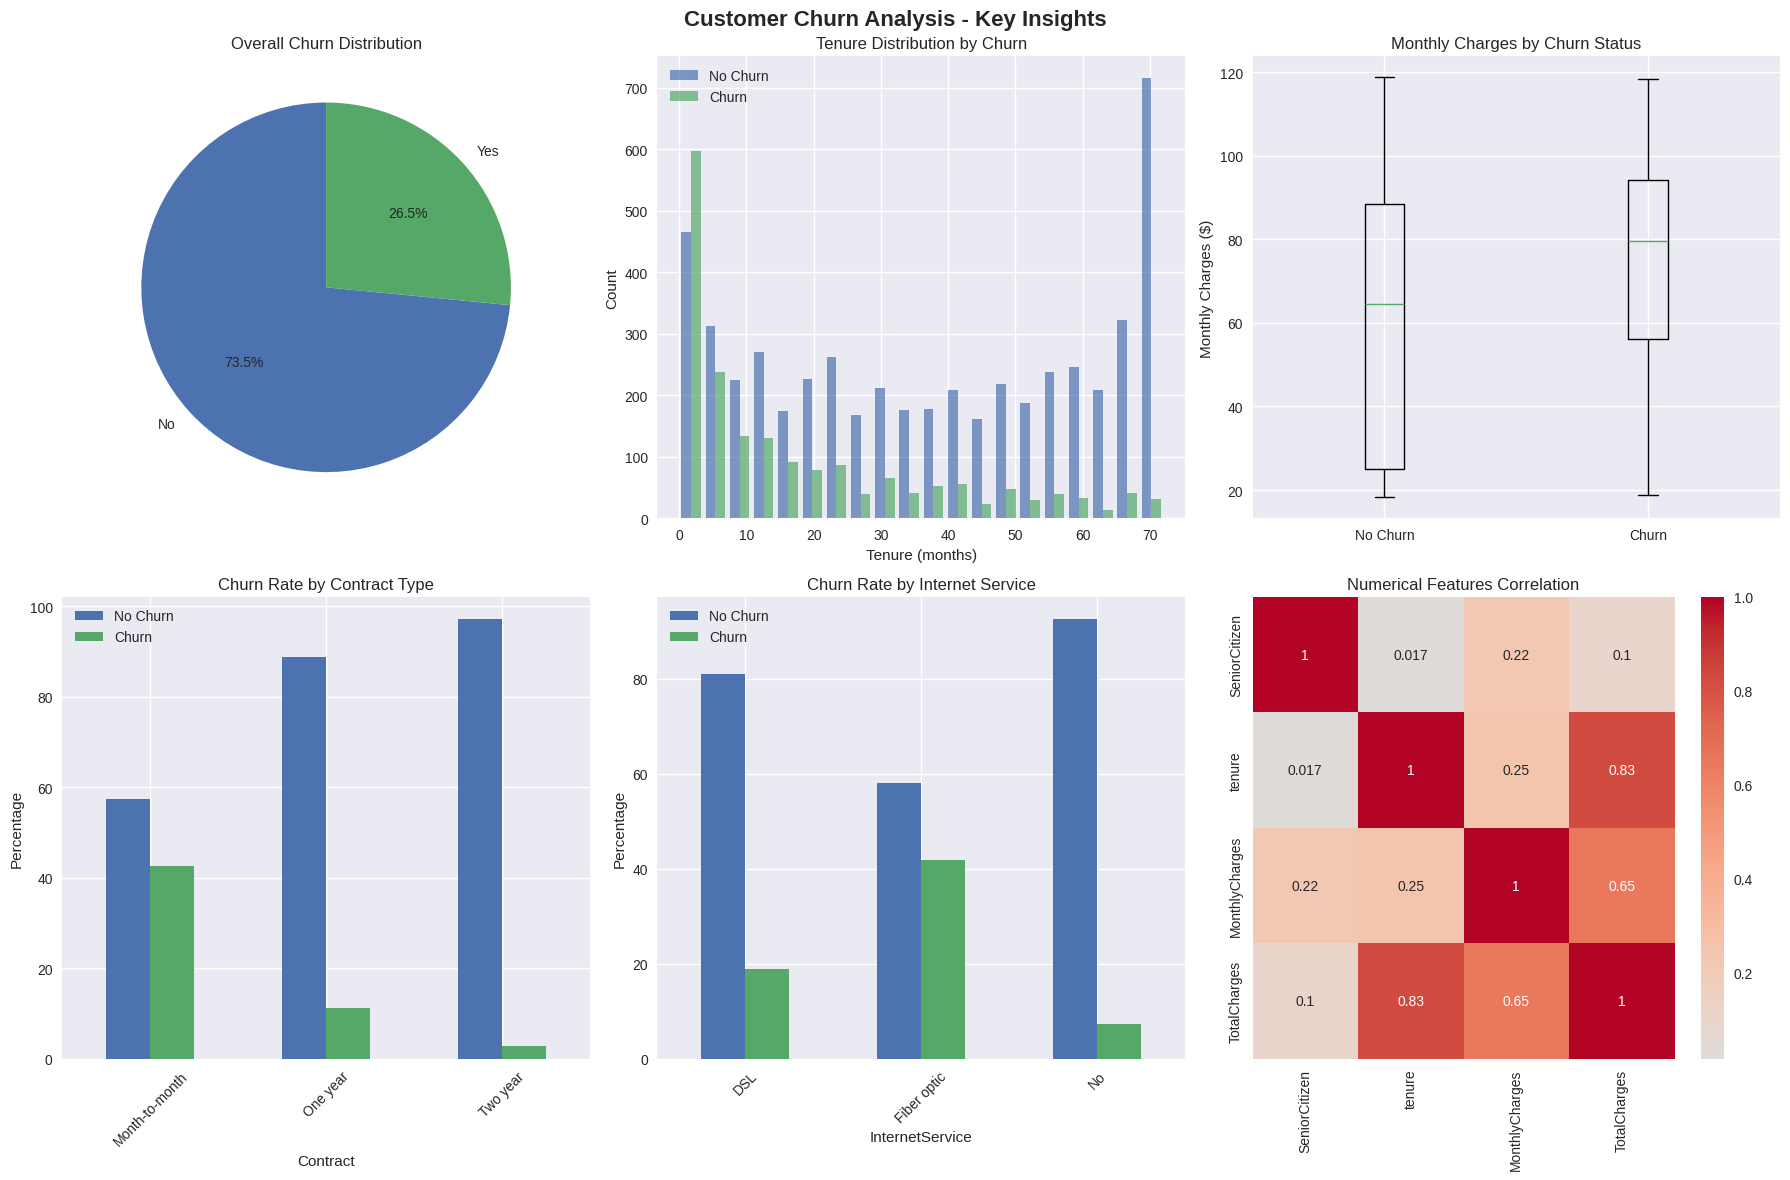

In [5]:
# Step 3: Create visualizations
create_visualizations(df)

In [6]:
# Step 4: Prepare features
X, y, categorical_features, numerical_features, label_encoder = prepare_features(df)


FEATURE PREPARATION
Categorical features (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical features (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Target classes: ['No' 'Yes']


In [7]:
# Step 5: Train and evaluate models
results, best_models, X_test, y_test = train_and_evaluate_models(
    X, y, categorical_features, numerical_features
)


MODEL TRAINING AND EVALUATION
Training set size: (5634, 19)
Test set size: (1409, 19)

Creating preprocessing pipeline...
Preprocessing pipeline created successfully!

Training Logistic Regression...
logistic_regression pipeline created successfully!
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation AUC: 0.8459
Test AUC: 0.8413

Training Random Forest...
random_forest pipeline created successfully!
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best cross-validation AUC: 0.8433
Test AUC: 0.8417


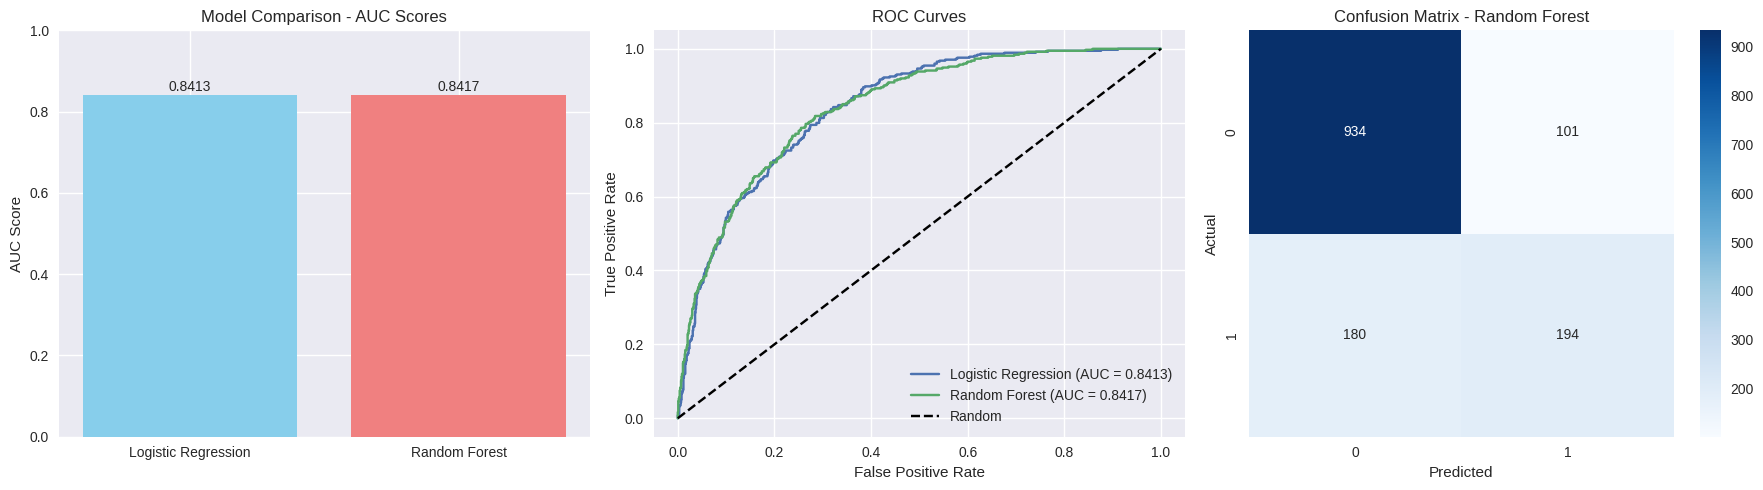

In [8]:
# Step 6: Plot model comparison
plot_model_comparison(results, X_test, y_test)

In [9]:
# Step 7: Export best pipeline
best_model_name = export_best_pipeline(best_models, results)


PIPELINE EXPORT
Best model: Random Forest
Test AUC: 0.8417
Pipeline exported to: best_churn_pipeline.joblib


In [10]:
# Step 8: Demonstrate pipeline loading and prediction
sample_data = X_test.head(10)
predictions, probabilities = load_and_predict('best_churn_pipeline.joblib', sample_data)


Pipeline loaded successfully from best_churn_pipeline.joblib
Sample predictions: [0 1 0 0 0]
Sample probabilities: [0.01241999 0.74626722 0.11380493 0.33487337 0.01575533]


In [13]:
print("\nPipeline completed successfully!")
print("\nSummary:")
for model_name, result in results.items():
    print(f"- {model_name.replace('_', ' ').title()}: AUC = {result['test_auc']:.4f}")


Pipeline completed successfully!

Summary:
- Logistic Regression: AUC = 0.8413
- Random Forest: AUC = 0.8417
